## Import Libraries

Importing neccessary libraries for the code to run.

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, QuantileTransformer, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LayerNormalization, GaussianNoise, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.constraints import MaxNorm
from sklearn.impute import KNNImputer
from scipy.stats import zscore

In [98]:
df = pd.read_json('data/thermomutdb.json')

print(df.shape)
print(df.columns.to_list())

cols_to_keep = [
    'PDB_wild',
    'ddg',
    'mutation_code',
    'pos',
    'mutation_type',
    'blosum62',
    'pam250',
    'ca_depth',
    'res_depth',
    'relative_bfactor',
    'phi',
    'psi',
    'sst',
    'rsa',
    'temperature',
    'ph',
]

df_filtered = df[cols_to_keep]
df_filtered.to_csv('data/thermomutdb_filtered.csv', index=False)
print(df_filtered.shape)
print(df_filtered.columns.tolist())
df_filtered.head(10)


(13337, 44)
['DOI', 'weight', 'blosum62', 'measure', 'pos', 'pdbs_template', 'year', 'protein', 'PDBs_template', 'id', 'aro', 'PDB_wild', 'reference', 'ca_depth', 'mut_count', 'neg', 'pdb_mutant', 'sul', 'relative_bfactor', 'mutation_type', 'source', 'mutation_code', 'swissprot', 'mutation_based', 'ph', 'neu', 'ddg', 'method', 'phi', 'psi', 'sst', 'rsa', 'effect', 'mutated_chain', 'res_depth', 'temperature', 'acc', 'don', 'dtm', 'pam250', 'length', 'uniprot', 'PMID', 'PIR_ID']
(13337, 16)
['PDB_wild', 'ddg', 'mutation_code', 'pos', 'mutation_type', 'blosum62', 'pam250', 'ca_depth', 'res_depth', 'relative_bfactor', 'phi', 'psi', 'sst', 'rsa', 'temperature', 'ph']


,PDB_wild,ddg,mutation_code,pos,mutation_type,blosum62,pam250,ca_depth,res_depth,relative_bfactor,phi,psi,sst,rsa,temperature,ph
0,1WQ5,4.60,E49M,0.0,Single,-1.0,0.0,4.14,3.53,3.47,-118.5,113.0,Strand,0.00,298.95,7.0
1,1WQ5,-2.50,E49Q,0.0,Single,-2.0,-2.0,4.14,3.53,3.47,-118.5,113.0,Strand,0.00,298.95,7.0
2,2LZM,-1.71,W138Y,0.0,Single,1.0,1.0,2.00,3.85,2.70,-47.0,-54.4,AlphaHelix,0.05,298.15,2.2
3,2LZM,-1.77,"W138Y,W126Y,W158Y",NaN,Multiple,0.0,1.0,NaN,NaN,NaN,NaN,NaN,None,NaN,298.15,2.5
4,2LZM,-1.82,"W138Y,W126Y,W158Y",NaN,Multiple,1.0,0.0,NaN,NaN,NaN,NaN,NaN,None,NaN,298.15,2.2
5,1TUP,-3.07,C242S,0.0,Single,-1.0,0.0,2.00,2.64,3.35,-59.9,106.9,None,0.12,283.15,7.2
6,1TUP,-4.78,F134L,0.0,Single,-2.0,-1.0,7.94,6.55,2.97,-115.6,128.7,Strand,0.00,283.15,7.2
7,1TUP,-4.54,F270C,0.0,Single,-1.0,0.0,4.68,5.85,2.61,-150.7,150.2,Strand,0.01,283.15,7.2
8,1TUP,-4.12,I195T,0.0,Single,-2.0,0.0,7.35,8.08,2.82,-106.1,126.9,Strand,0.06,283.15,7.2
9,1TUP,-3.19,I232T,0.0,Single,-4.0,-3.0,3.90,4.81,2.77,-126.6,135.1,Strand,0.08,283.15,7.2


In [99]:
# Extract wild-type and mutant amino acids from mutation code
# "A45G" means residue A at position 45 mutated to G
df_filtered['wild_type'] = df_filtered['mutation_code'].str[0]
df_filtered['mutant'] = df_filtered['mutation_code'].str[-1]

# Missing values
print("\nMissing values in each column:")
print(df_filtered.isnull().sum())

# Handle missing values - fill with median for numerical columns
numerical_cols = ['blosum62', 'pam250', 'ca_depth', 'res_depth', 
                 'relative_bfactor', 'phi', 'psi', 'rsa', 
                 'temperature', 'ph', 'ddg']

for col in numerical_cols:
    if df_filtered[col].isnull().sum() > 0:
        df_filtered[col] = df_filtered[col].fillna(df_filtered[col].median())

# For categorical columns, fill with mode
categorical_cols = ['sst', 'mutation_type', 'wild_type', 'mutant']
for col in categorical_cols:
    if df_filtered[col].isnull().sum() > 0:
        df_filtered[col] = df_filtered[col].fillna(df_filtered[col].mode()[0])

# Drop any remaining rows with NaN values
df_filtered = df_filtered.dropna()
print(f"Dataset after handling missing values: {df_filtered.shape[0]} entries")

df_filtered.head(10)


Missing values in each column:
PDB_wild             372
ddg                 2958
mutation_code          0
pos                 3184
mutation_type          0
blosum62            2137
pam250              2137
ca_depth            2918
res_depth           2918
relative_bfactor    2920
phi                 2918
psi                 2918
sst                 2918
rsa                 2918
temperature         1366
ph                    30
wild_type              0
mutant                 0
dtype: int64
Dataset after handling missing values: 10153 entries


/var/folders/pp/z15j_rhn22z16k937sk24y340000gn/T/ipykernel_28322/1107453754.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['wild_type'] = df_filtered['mutation_code'].str[0]
/var/folders/pp/z15j_rhn22z16k937sk24y340000gn/T/ipykernel_28322/1107453754.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['mutant'] = df_filtered['mutation_code'].str[-1]
/var/folders/pp/z15j_rhn22z16k937sk24y340000gn/T/ipykernel_28322/1107453754.py:17: SettingWithCopyWarning: 
A value is trying to be 

,PDB_wild,ddg,mutation_code,pos,mutation_type,blosum62,pam250,ca_depth,res_depth,relative_bfactor,phi,psi,sst,rsa,temperature,ph,wild_type,mutant
0,1WQ5,4.60,E49M,0.0,Single,-1.0,0.0,4.14,3.53,3.47,-118.5,113.0,Strand,0.00,298.95,7.0,E,M
1,1WQ5,-2.50,E49Q,0.0,Single,-2.0,-2.0,4.14,3.53,3.47,-118.5,113.0,Strand,0.00,298.95,7.0,E,Q
2,2LZM,-1.71,W138Y,0.0,Single,1.0,1.0,2.00,3.85,2.70,-47.0,-54.4,AlphaHelix,0.05,298.15,2.2,W,Y
5,1TUP,-3.07,C242S,0.0,Single,-1.0,0.0,2.00,2.64,3.35,-59.9,106.9,None,0.12,283.15,7.2,C,S
6,1TUP,-4.78,F134L,0.0,Single,-2.0,-1.0,7.94,6.55,2.97,-115.6,128.7,Strand,0.00,283.15,7.2,F,L
7,1TUP,-4.54,F270C,0.0,Single,-1.0,0.0,4.68,5.85,2.61,-150.7,150.2,Strand,0.01,283.15,7.2,F,C
8,1TUP,-4.12,I195T,0.0,Single,-2.0,0.0,7.35,8.08,2.82,-106.1,126.9,Strand,0.06,283.15,7.2,I,T
9,1TUP,-3.19,I232T,0.0,Single,-4.0,-3.0,3.90,4.81,2.77,-126.6,135.1,Strand,0.08,283.15,7.2,I,T
10,1TUP,-3.29,I255F,0.0,Single,-1.0,0.0,7.27,7.07,2.75,-103.6,117.2,Strand,0.00,283.15,7.2,I,F
11,1TUP,-2.98,L145Q,0.0,Single,-2.0,0.0,6.42,6.44,2.96,-97.0,128.5,Strand,0.03,283.15,7.2,L,Q



Basic statistics for ddG:
count    10153.000000
mean        -1.097591
std          1.930666
min        -23.210000
25%         -1.770335
50%         -0.740000
75%         -0.130000
max         13.700000
Name: ddg, dtype: float64


Text(0, 0.5, 'Frequency')

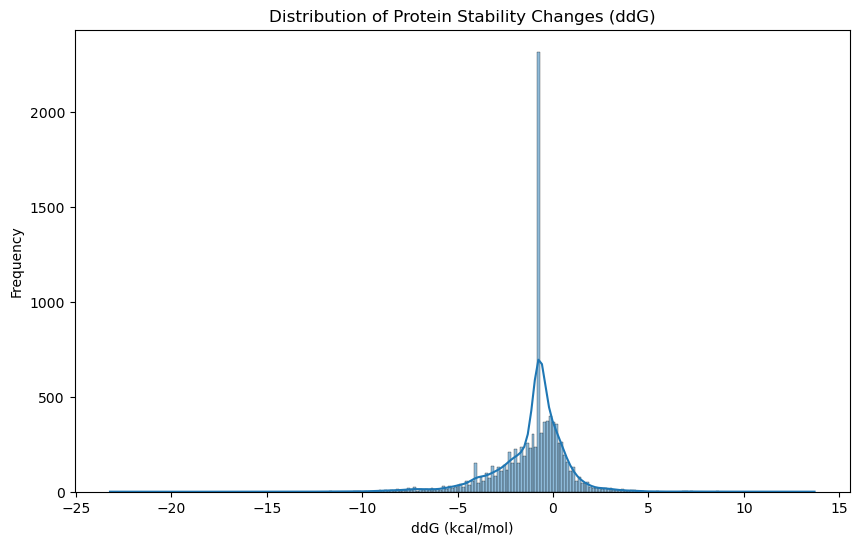

In [100]:
print("\nBasic statistics for ddG:")
print(df_filtered['ddg'].describe())

# Visualize the distribution of ddG values
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['ddg'], kde=True)
plt.title('Distribution of Protein Stability Changes (ddG)')
plt.xlabel('ddG (kcal/mol)')
plt.ylabel('Frequency')

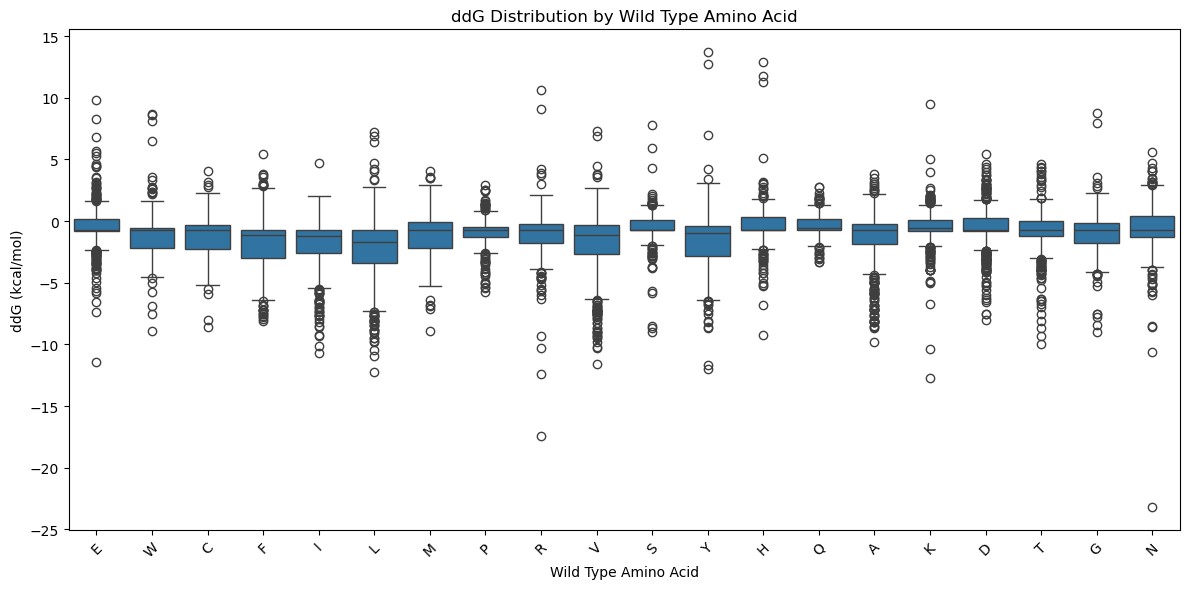

In [101]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='wild_type', y='ddg', data=df_filtered)
plt.title('ddG Distribution by Wild Type Amino Acid')
plt.xlabel('Wild Type Amino Acid')
plt.ylabel('ddG (kcal/mol)')
plt.xticks(rotation=45)
plt.tight_layout()

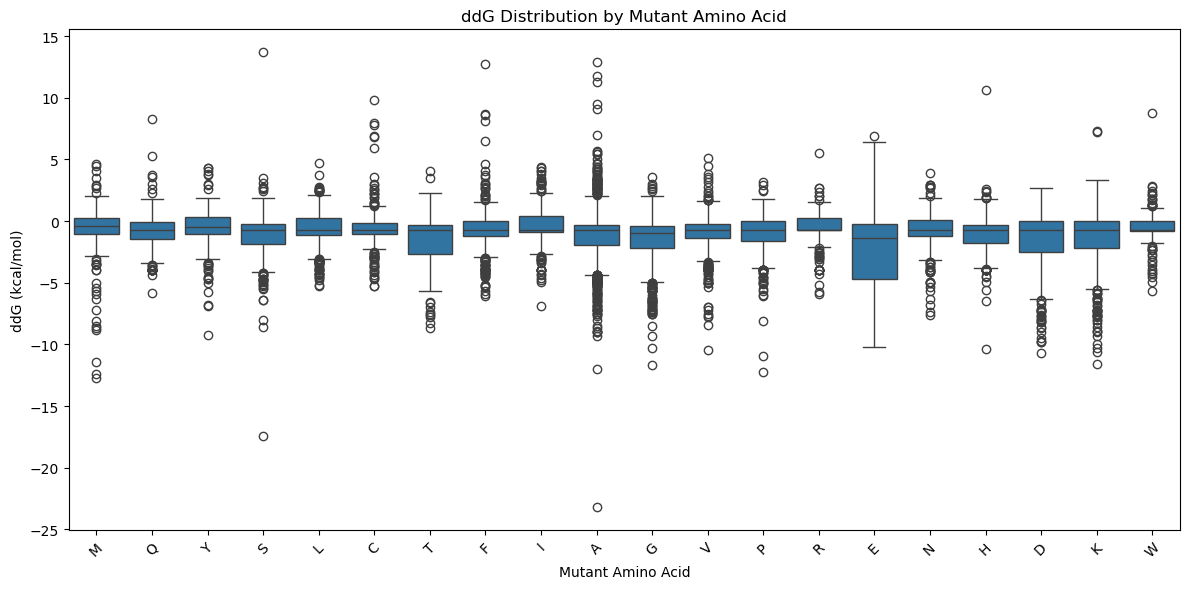

In [102]:

plt.figure(figsize=(12, 6))
sns.boxplot(x='mutant', y='ddg', data=df_filtered)
plt.title('ddG Distribution by Mutant Amino Acid')
plt.xlabel('Mutant Amino Acid')
plt.ylabel('ddG (kcal/mol)')
plt.xticks(rotation=45)
plt.tight_layout()

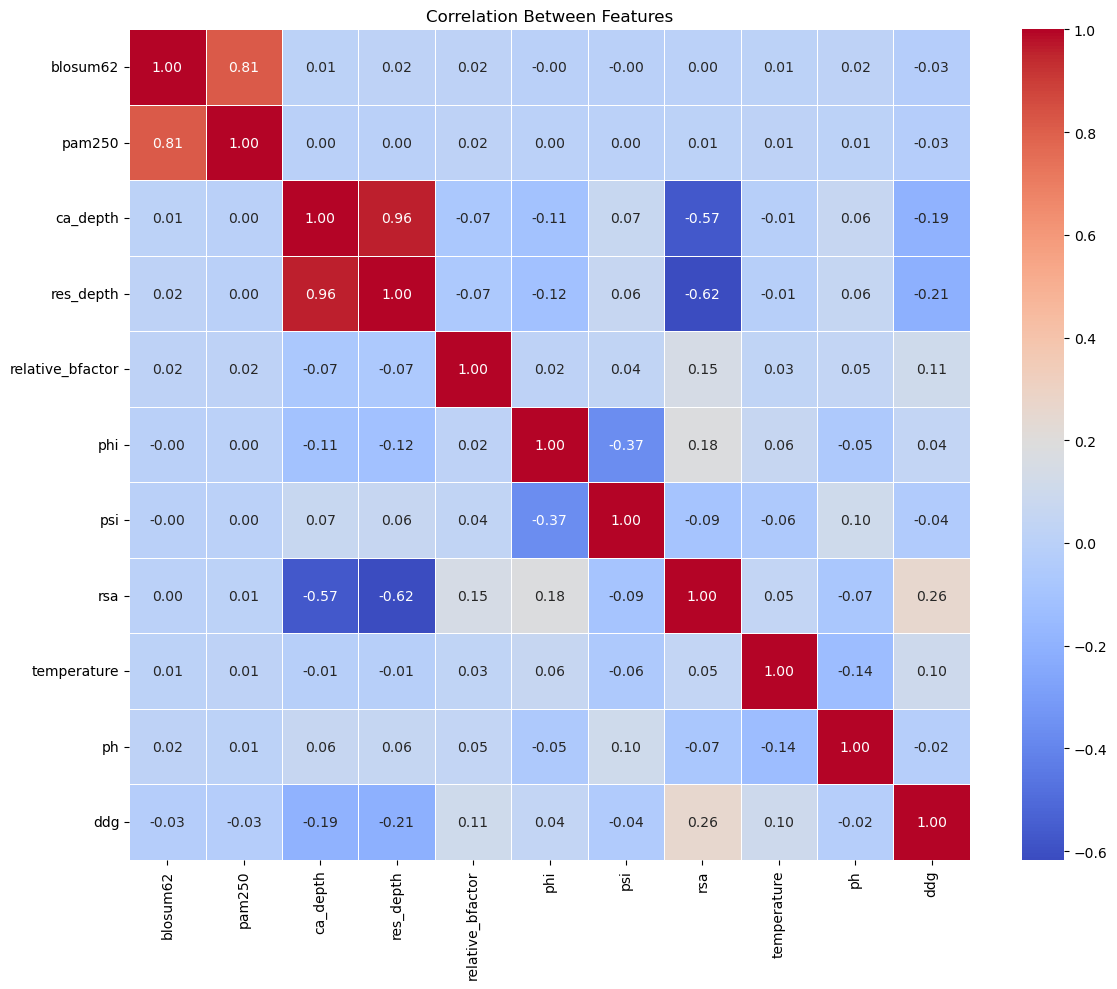

In [103]:
correlation = df_filtered[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Between Features')
plt.tight_layout()

In [106]:


# One-hot encode categorical variables
df_encoded = df_filtered.copy()

# One-hot encode secondary structure (sst)
sst_dummies = pd.get_dummies(df_encoded['sst'], prefix='sst')
df_encoded = pd.concat([df_encoded, sst_dummies], axis=1)

# One-hot encode mutation type
mutation_type_dummies = pd.get_dummies(df_encoded['mutation_type'], prefix='mutation_type')
df_encoded = pd.concat([df_encoded, mutation_type_dummies], axis=1)

# One-hot encode wild-type and mutant amino acids
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
for aa in amino_acids:
    df_encoded[f'wild_type_{aa}'] = (df_encoded['wild_type'] == aa).astype(int)
    df_encoded[f'mutant_{aa}'] = (df_encoded['mutant'] == aa).astype(int)

# Create physicochemical property changes
# Hydrophobicity values (Kyte-Doolittle scale)
hydrophobicity = {
    'A': 1.8, 'C': 2.5, 'D': -3.5, 'E': -3.5, 'F': 2.8, 'G': -0.4, 'H': -3.2,
    'I': 4.5, 'K': -3.9, 'L': 3.8, 'M': 1.9, 'N': -3.5, 'P': -1.6, 'Q': -3.5,
    'R': -4.5, 'S': -0.8, 'T': -0.7, 'V': 4.2, 'W': -0.9, 'Y': -1.3
}

# Volume values
volume = {
    'A': 88.6, 'C': 108.5, 'D': 111.1, 'E': 138.4, 'F': 189.9, 'G': 60.1, 'H': 153.2,
    'I': 166.7, 'K': 168.6, 'L': 166.7, 'M': 162.9, 'N': 114.1, 'P': 112.7, 'Q': 143.8,
    'R': 173.4, 'S': 89.0, 'T': 116.1, 'V': 140.0, 'W': 227.8, 'Y': 193.6
}

# Charge values
charge = {
    'A': 0, 'C': 0, 'D': -1, 'E': -1, 'F': 0, 'G': 0, 'H': 0.1, 'I': 0, 'K': 1,
    'L': 0, 'M': 0, 'N': 0, 'P': 0, 'Q': 0, 'R': 1, 'S': 0, 'T': 0, 'V': 0, 'W': 0, 'Y': 0
}

df_encoded['hydrophobicity_change'] = df_encoded.apply(
    lambda row: hydrophobicity.get(row['mutant'], 0) - hydrophobicity.get(row['wild_type'], 0), axis=1
)

df_encoded['volume_change'] = df_encoded.apply(
    lambda row: volume.get(row['mutant'], 0) - volume.get(row['wild_type'], 0), axis=1
)

df_encoded['charge_change'] = df_encoded.apply(
    lambda row: charge.get(row['mutant'], 0) - charge.get(row['wild_type'], 0), axis=1
)

# Drop original categorical columns that we've one-hot encoded
cols_to_drop = ['sst', 'mutation_type', 'wild_type', 'mutant', 'mutation_code', 'PDB_wild']
df_encoded = df_encoded.drop(columns=cols_to_drop)

# Outlier handling
numerical_cols_for_outlier_handling = ['blosum62', 'pam250', 'ca_depth', 'res_depth',
                 'relative_bfactor', 'phi', 'psi', 'rsa',
                 'temperature', 'ph', 'hydrophobicity_change', 'volume_change', 'charge_change', 'ddg'] # Include ddg

for col in numerical_cols_for_outlier_handling:
    # Calculate z-scores
    z_scores = zscore(df_encoded[col])
    # Define a threshold for outliers (e.g., z-score > 3 or < -3)
    outlier_threshold = 3
    # Remove rows where the z-score is above the threshold
    df_encoded = df_encoded[(z_scores <= outlier_threshold) & (z_scores >= -outlier_threshold)]

print(f"Dataset after feature engineering: {df_encoded.shape[1]} features")

df_encoded.head(10)

Dataset after feature engineering: 64 features


,ddg,pos,blosum62,pam250,ca_depth,res_depth,relative_bfactor,phi,psi,rsa,...,mutant_T,wild_type_V,mutant_V,wild_type_W,mutant_W,wild_type_Y,mutant_Y,hydrophobicity_change,volume_change,charge_change
0,4.60,0.0,-1.0,0.0,4.14,3.53,3.47,-118.5,113.0,0.00,...,0,0,0,0,0,0,0,5.4,24.5,1.0
1,-2.50,0.0,-2.0,-2.0,4.14,3.53,3.47,-118.5,113.0,0.00,...,0,0,0,0,0,0,0,0.0,5.4,1.0
2,-1.71,0.0,1.0,1.0,2.00,3.85,2.70,-47.0,-54.4,0.05,...,0,0,0,1,0,0,1,-0.4,-34.2,0.0
5,-3.07,0.0,-1.0,0.0,2.00,2.64,3.35,-59.9,106.9,0.12,...,0,0,0,0,0,0,0,-3.3,-19.5,0.0
6,-4.78,0.0,-2.0,-1.0,7.94,6.55,2.97,-115.6,128.7,0.00,...,0,0,0,0,0,0,0,1.0,-23.2,0.0
7,-4.54,0.0,-1.0,0.0,4.68,5.85,2.61,-150.7,150.2,0.01,...,0,0,0,0,0,0,0,-0.3,-81.4,0.0
9,-3.19,0.0,-4.0,-3.0,3.90,4.81,2.77,-126.6,135.1,0.08,...,1,0,0,0,0,0,0,-5.2,-50.6,0.0
10,-3.29,0.0,-1.0,0.0,7.27,7.07,2.75,-103.6,117.2,0.00,...,0,0,0,0,0,0,0,-1.7,23.2,0.0
11,-2.98,0.0,-2.0,0.0,6.42,6.44,2.96,-97.0,128.5,0.03,...,0,0,0,0,0,0,0,-7.3,-22.9,0.0
12,-3.18,0.0,0.0,1.0,4.88,4.04,2.78,-97.3,21.3,0.04,...,0,0,0,0,0,0,0,2.6,3.8,0.0


In [ ]:
## Trial

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

# Assuming `df_encoded` is the dataset after feature engineering and `target` is the target column
X = df_encoded.drop(columns=['ddg'])  # Replace 'target' with the actual target column name
y = df_encoded['ddg']  # Replace 'target' with the actual target column name

# Train a Random Forest model to determine feature importance
rf = RandomForestRegressor(random_state=42)
rf.fit(X, y)

# Get feature importances
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

# Select the top 20 features
top_20_features = feature_importances.head(20)['feature'].tolist()

# Create a new dataset with only the top 20 features
df_top_20 = df_encoded[top_20_features + ['ddg']]  # Include the target column

print(f"Dataset with top 20 features: {df_top_20.shape[1]} features")
df_top_20.head(10)

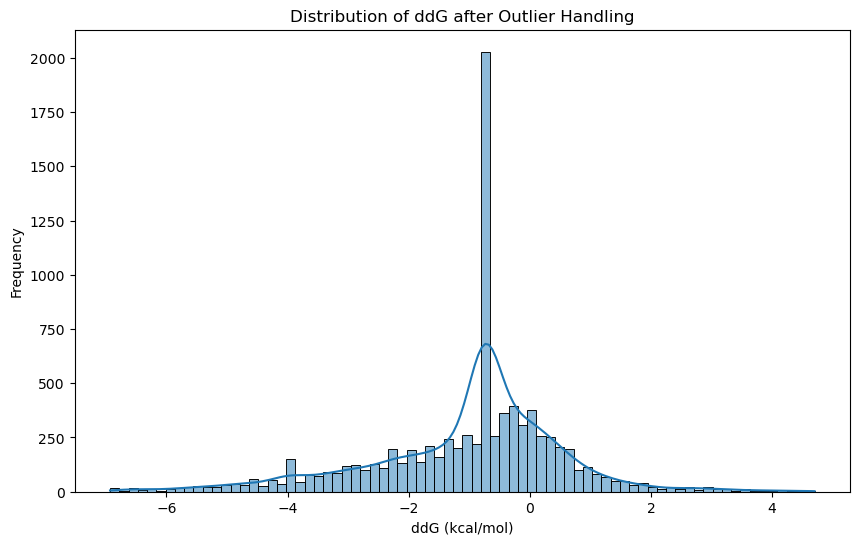

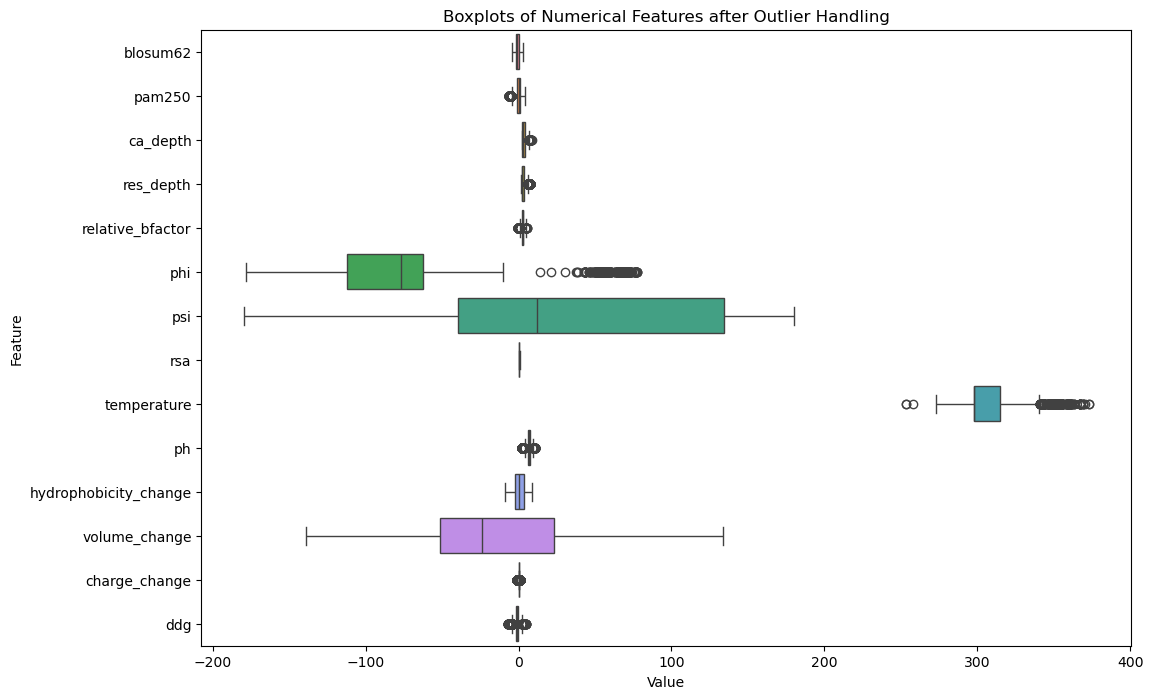

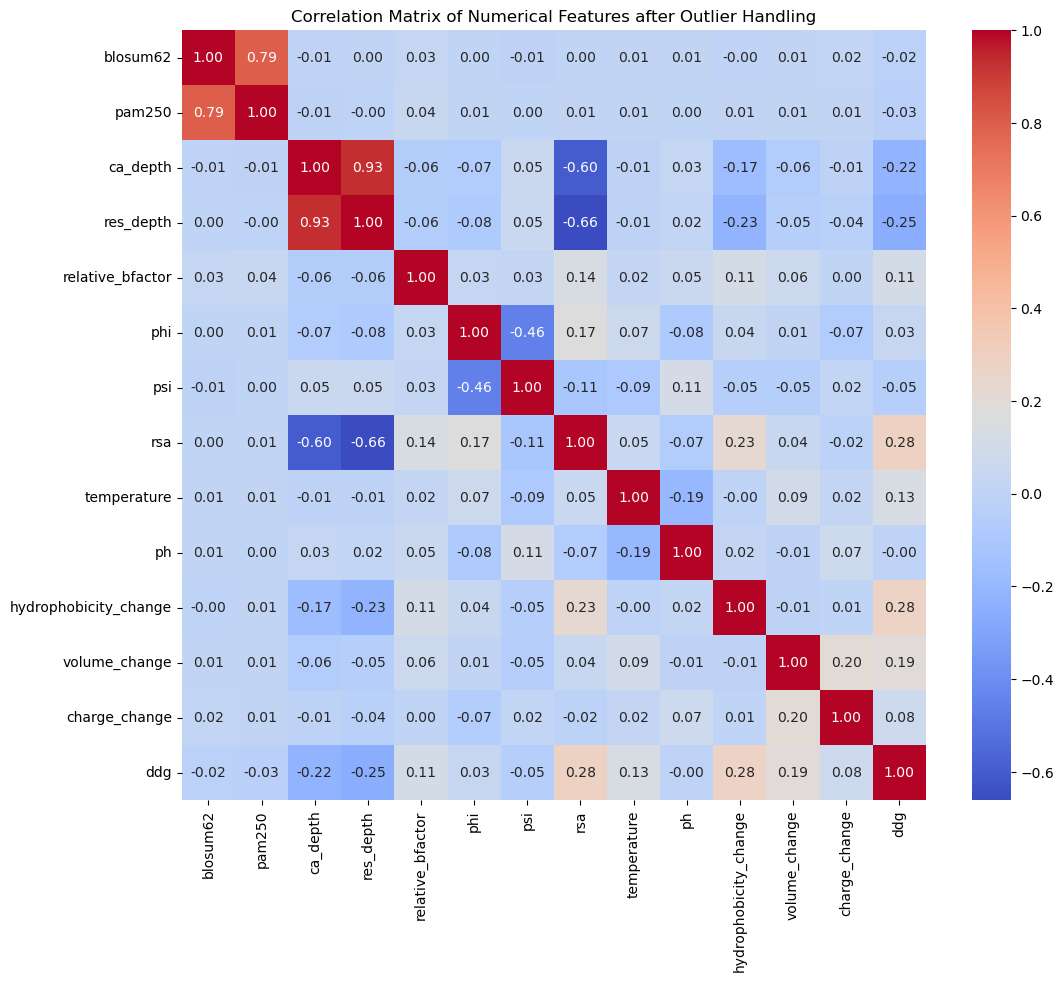

In [107]:
plt.figure(figsize=(10, 6))
sns.histplot(df_encoded['ddg'], kde=True)
plt.title('Distribution of ddG after Outlier Handling')
plt.xlabel('ddG (kcal/mol)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(data=df_encoded[numerical_cols_for_outlier_handling], orient="h")
plt.title('Boxplots of Numerical Features after Outlier Handling')
plt.xlabel('Value')
plt.ylabel('Feature')
plt.show()

correlation_matrix = df_encoded[numerical_cols_for_outlier_handling].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features after Outlier Handling')
plt.show()


In [116]:
# Define features and target
X = df_encoded.drop(columns=['ddg'])
y = df_encoded['ddg']

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Scale the numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

tf.random.set_seed(42)
np.random.seed(42)


Training set: 6213 samples
Validation set: 1332 samples
Test set: 1332 samples


In [117]:

input_shape = X_train_scaled.shape[1]

model = Sequential([
    Dense(256, activation='relu', input_shape=(input_shape,), kernel_regularizer=l2(0.001), kernel_constraint=MaxNorm(3)),
    BatchNormalization(),
    GaussianNoise(0.1),
    Dropout(0.4),

    Dense(128, activation='relu', kernel_regularizer=l2(0.001), kernel_constraint=MaxNorm(3)),
    BatchNormalization(),
    GaussianNoise(0.1),
    Dropout(0.3),

    Dense(64, activation='relu', kernel_regularizer=l2(0.0005), kernel_constraint=MaxNorm(3)),
    BatchNormalization(),
    GaussianNoise(0.05),
    Dropout(0.2),

    Dense(32, activation='relu', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.1),

    Dense(1)
])

optimizer = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])


In [118]:
# Callbacks for better training
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('models/best_model.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)


# Train the model
history = model.fit(
    X_train_scaled, y_train,
    epochs=300,  # Increased epochs
    batch_size=64,  # Increased batch size
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1
)


Epoch 1/300
98/98 [==============================] - 4s 7ms/step - loss: 4.4787 - mae: 1.5464 - val_loss: 3.0838 - val_mae: 1.1414 - lr: 0.0010
Epoch 2/300
98/98 [==============================] - 0s 5ms/step - loss: 3.1158 - mae: 1.2471 - val_loss: 2.6831 - val_mae: 1.0723 - lr: 0.0010
Epoch 3/300
98/98 [==============================] - 0s 4ms/step - loss: 2.7151 - mae: 1.1457 - val_loss: 2.4911 - val_mae: 1.0412 - lr: 0.0010
Epoch 4/300
98/98 [==============================] - 0s 5ms/step - loss: 2.5863 - mae: 1.1100 - val_loss: 2.4513 - val_mae: 1.0296 - lr: 0.0010
Epoch 5/300
98/98 [==============================] - 0s 5ms/step - loss: 2.4818 - mae: 1.0761 - val_loss: 2.3898 - val_mae: 1.0134 - lr: 0.0010
Epoch 6/300
98/98 [==============================] - 0s 4ms/step - loss: 2.3918 - mae: 1.0515 - val_loss: 2.3972 - val_mae: 1.0181 - lr: 0.0010
Epoch 7/300
98/98 [==============================] - 0s 4ms/step - loss: 2.3734 - mae: 1.0485 - val_loss: 2.3652 - val_mae: 1.0050 - lr:

In [119]:
# Load the best model
model = load_model('models/best_model.h5')  # Load the best model
y_pred = model.predict(X_test_scaled).flatten()
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

42/42 [==============================] - 0s 1ms/step
Mean Squared Error: 1.7275
Root Mean Squared Error: 1.3143
Mean Absolute Error: 0.8993
R² Score: 0.3667


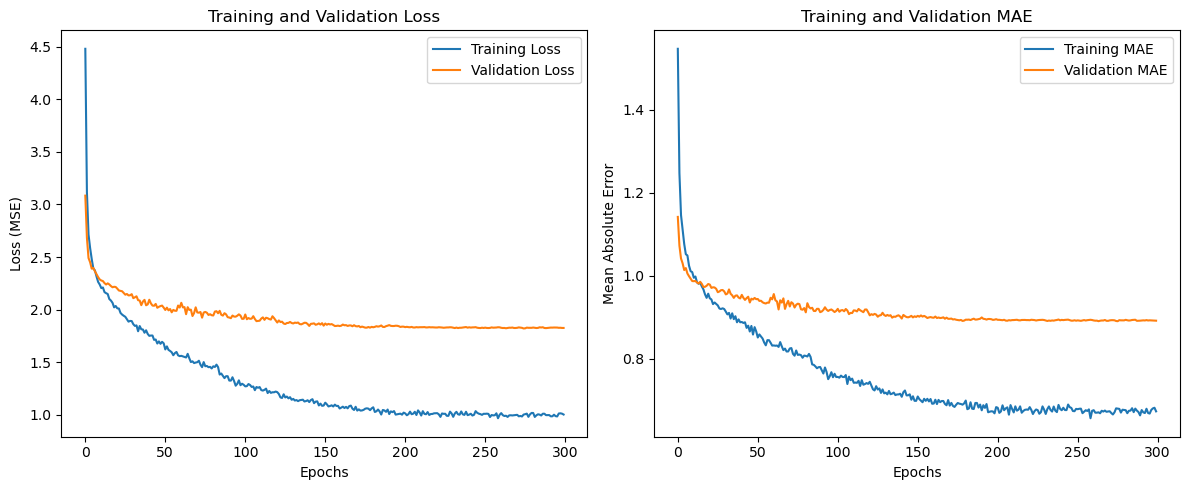

In [120]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('Training and Validation MAE')
plt.legend()
plt.tight_layout()
plt.show()

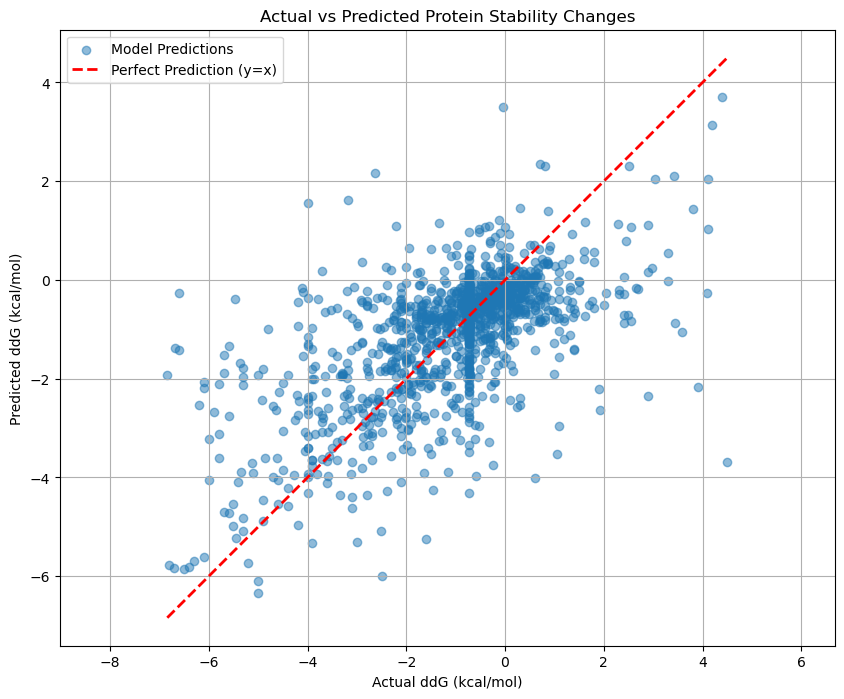

In [141]:
# Actual vs Predicted plot
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.5, label='Model Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction (y=x)')
plt.xlabel('Actual ddG (kcal/mol)')
plt.ylabel('Predicted ddG (kcal/mol)')
plt.title('Actual vs Predicted Protein Stability Changes')
plt.grid(True); plt.legend(); plt.axis('equal'); plt.show()

Text(0.5, 1.0, 'Distribution of Prediction Errors')

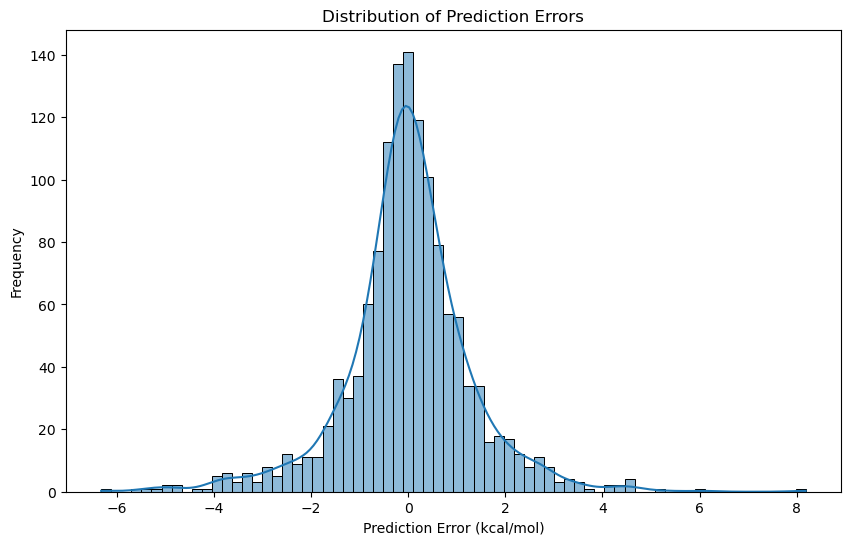

In [122]:
plt.figure(figsize=(10, 6))
errors = y_test - y_pred
sns.histplot(errors, kde=True)
plt.xlabel('Prediction Error (kcal/mol)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')

In [131]:
def plot_feature_importance(model, feature_names):
    """
    Plots the feature importance of a trained neural network model.  It averages
    the absolute values of the weights connecting the input layer to the first
    hidden layer.

    Args:
        model: A trained TensorFlow Keras Sequential model.
        feature_names: A list of feature names, corresponding to the columns
                       of the input data used to train the model.

    Returns:
        None.  Displays a plot of the top 20 most important features.
    """
    # Get the weights from the input layer to the first hidden layer
    try:
        weights = model.layers[0].get_weights()[0]
    except IndexError:
        print("Model does not have a first layer with weights.  Cannot plot feature importance.")
        return

    # Calculate the average absolute weight for each feature
    feature_importance = np.abs(weights).mean(axis=1)

    # Create a DataFrame to hold feature names and their importance scores
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    })

    # Sort the DataFrame by importance score in descending order
    feature_importance_df = feature_importance_df.sort_values(
        'Importance', ascending=False)

    # # Create the plot
    # plt.figure(figsize=(12, 10))
    # sns.barplot(x='Importance', y='Feature',
    #             data=feature_importance_df.head(20))  # Show top 20 features
    # plt.title('Top 20 Most Important Features')
    # plt.tight_layout()
    # plt.show()

    return feature_importance_df

# Plot feature importance
feature_importance_scores= plot_feature_importance(model, X.columns)
print(feature_importance_scores)


                 Feature    Importance
5       relative_bfactor  1.040088e-01
8                    rsa  9.168071e-02
9            temperature  8.858742e-02
10                    ph  8.648903e-02
6                    phi  8.210213e-02
..                   ...           ...
46           wild_type_Q  3.932647e-02
56           wild_type_W  3.905334e-02
33              mutant_H  3.716596e-02
16           sst_PiHelix  2.434128e-02
19  mutation_type_Single  3.029294e-33

[63 rows x 2 columns]


In [132]:
# Define the weighting factor
weight_factor = 2.0 # Example: Make top features twice as impactful in magnitude
top_n_features = 20

# Get the names of the top N features from the previous importance analysis
if 'feature_importance_scores' in locals() and feature_importance_scores is not None:
    top_features_list = feature_importance_scores.head(top_n_features)['Feature'].tolist()
    print(f"Identified Top {top_n_features} Features for Weighting:")
    print(top_features_list)
else:
    # Fallback or error if feature importance wasn't calculated
    print("Error: Feature importance scores not found. Cannot proceed with weighting.")
    # You might want to re-run the feature importance calculation here if needed
    # or define the list manually based on previous runs if necessary.
    top_features_list = [] # Prevent crashing, but weighting won't happen

if top_features_list:
    # Get the column indices corresponding to the top features
    feature_indices = [X.columns.get_loc(feature) for feature in top_features_list if feature in X.columns]

    # Create copies of the scaled data to apply weighting
    X_train_weighted_scaled = X_train_scaled.copy()
    X_val_weighted_scaled = X_val_scaled.copy()
    X_test_weighted_scaled = X_test_scaled.copy()

    # Apply the weighting factor to the selected feature columns
    print(f"\nApplying weight factor ({weight_factor}) to top {len(feature_indices)} features...")
    for idx in feature_indices:
        X_train_weighted_scaled[:, idx] *= weight_factor
        X_val_weighted_scaled[:, idx] *= weight_factor
        X_test_weighted_scaled[:, idx] *= weight_factor

    print("Weighted datasets created.")

    # Sanity check: Compare standard deviation before and after weighting for one feature
    if feature_indices:
        feature_idx_to_check = feature_indices[0]
        feature_name_checked = X.columns[feature_idx_to_check]
        print(f"\nSanity Check for feature '{feature_name_checked}':")
        print(f"  Std Dev in original scaled train data: {np.std(X_train_scaled[:, feature_idx_to_check]):.4f}")
        print(f"  Std Dev in weighted scaled train data: {np.std(X_train_weighted_scaled[:, feature_idx_to_check]):.4f}")

Identified Top 20 Features for Weighting:
['relative_bfactor', 'rsa', 'temperature', 'ph', 'phi', 'psi', 'ca_depth', 'pam250', 'blosum62', 'res_depth', 'sst_None', 'sst_Strand', 'wild_type_I', 'wild_type_V', 'sst_Bend', 'sst_Turn', 'pos', 'sst_AlphaHelix', 'mutant_G', 'mutant_V']

Applying weight factor (2.0) to top 20 features...
Weighted datasets created.

Sanity Check for feature 'relative_bfactor':
  Std Dev in original scaled train data: 1.0000
  Std Dev in weighted scaled train data: 2.0000


In [133]:
input_shape_weighted = X_train_weighted_scaled.shape[1]

weighted_model = Sequential([
    Dense(256, activation='relu', input_shape=(input_shape_weighted,),
            kernel_regularizer=l2(0.001), kernel_constraint=MaxNorm(3)),
    BatchNormalization(),
    GaussianNoise(0.1),
    Dropout(0.4),

    Dense(128, activation='relu',
            kernel_regularizer=l2(0.001), kernel_constraint=MaxNorm(3)),
    BatchNormalization(),
    GaussianNoise(0.1),
    Dropout(0.3),

    Dense(64, activation='relu',
            kernel_regularizer=l2(0.0005), kernel_constraint=MaxNorm(3)),
    BatchNormalization(),
    GaussianNoise(0.05),
    Dropout(0.2),

    Dense(32, activation='relu',
            kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.1),

    Dense(1)
])

# Re-compile the model (identical settings)
optimizer_weighted = Nadam(learning_rate=0.001)
weighted_model.compile(optimizer=optimizer_weighted, loss='mse', metrics=['mae'])

print("\nWeighted model re-defined and compiled.")
weighted_model.summary() 


Weighted model re-defined and compiled.
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 256)               16384     
                                                                 
 batch_normalization_43 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 gaussian_noise_30 (Gaussian  (None, 256)              0         
 Noise)                                                          
                                                                 
 dropout_43 (Dropout)        (None, 256)               0         
                                                                 
 dense_57 (Dense)            (None, 128)               32896     
                                                                 
 batch_norma

In [134]:
#Define new callbacks for the weighted model
early_stopping_weighted = EarlyStopping(monitor='val_loss', patience=50, verbose=1, restore_best_weights=True)
# Save to a different file
model_checkpoint_weighted = ModelCheckpoint('models/best_ddg_model_weighted.keras',
                                            save_best_only=True,
                                            monitor='val_loss',
                                            verbose=1)
reduce_lr_weighted = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15,
                                        min_lr=1e-6, verbose=1)

callbacks_list_weighted = [early_stopping_weighted, model_checkpoint_weighted, reduce_lr_weighted]

print("\nStarting weighted model training...")

history_weighted = weighted_model.fit(
    X_train_weighted_scaled, y_train,
    epochs=300,
    batch_size=64,
    validation_data=(X_val_weighted_scaled, y_val),
    callbacks=callbacks_list_weighted,
    verbose=1
)

print("\nWeighted model training finished.")


Starting weighted model training...
Epoch 1/300
90/98 [==========================>...] - ETA: 0s - loss: 4.1044 - mae: 1.4645
Epoch 1: val_loss improved from inf to 3.04240, saving model to models/best_ddg_model_weighted.keras
98/98 [==============================] - 5s 8ms/step - loss: 4.0367 - mae: 1.4512 - val_loss: 3.0424 - val_mae: 1.1281 - lr: 0.0010
Epoch 2/300
92/98 [===========================>..] - ETA: 0s - loss: 2.9634 - mae: 1.2064
Epoch 2: val_loss improved from 3.04240 to 2.62399, saving model to models/best_ddg_model_weighted.keras
98/98 [==============================] - 0s 5ms/step - loss: 2.9441 - mae: 1.2026 - val_loss: 2.6240 - val_mae: 1.0725 - lr: 0.0010
Epoch 3/300
85/98 [=========================>....] - ETA: 0s - loss: 2.6857 - mae: 1.1421
Epoch 3: val_loss improved from 2.62399 to 2.47786, saving model to models/best_ddg_model_weighted.keras
98/98 [==============================] - 0s 5ms/step - loss: 2.6672 - mae: 1.1386 - val_loss: 2.4779 - val_mae: 1.0452

In [136]:
print("Loading best weighted model from checkpoint...")
best_weighted_model = load_model('models/best_ddg_model_weighted.keras')

# Evaluate on the weighted test set
print("\nEvaluating weighted model on the weighted test set:")
test_loss_w, test_mae_w = best_weighted_model.evaluate(X_test_weighted_scaled, y_test, verbose=0)

# Make predictions
y_pred_w = best_weighted_model.predict(X_test_weighted_scaled).flatten()

# Calculate metrics
mse_w = mean_squared_error(y_test, y_pred_w)
rmse_w = np.sqrt(mse_w)
r2_w = r2_score(y_test, y_pred_w)

print(f"\nWeighted Model Test Set Performance:")
print(f"  Mean Squared Error (MSE):      {mse_w:.4f}")
print(f"  Root Mean Squared Error (RMSE):{rmse_w:.4f}")
print(f"  Mean Absolute Error (MAE):     {test_mae_w:.4f}")
print(f"  R-squared (R²) Score:          {r2_w:.4f}")

print("\n--- Comparison ---")
print(f"Original Model R²: {r2:.4f}, MAE: {mae:.4f}")
print(f"Weighted Model R²: {r2_w:.4f}, MAE: {test_mae_w:.4f}")

Loading best weighted model from checkpoint...

Evaluating weighted model on the weighted test set:
42/42 [==============================] - 0s 991us/step

Weighted Model Test Set Performance:
  Mean Squared Error (MSE):      1.6882
  Root Mean Squared Error (RMSE):1.2993
  Mean Absolute Error (MAE):     0.8833
  R-squared (R²) Score:          0.3810

--- Comparison ---
Original Model R²: 0.3667, MAE: 0.8993
Weighted Model R²: 0.3810, MAE: 0.8833


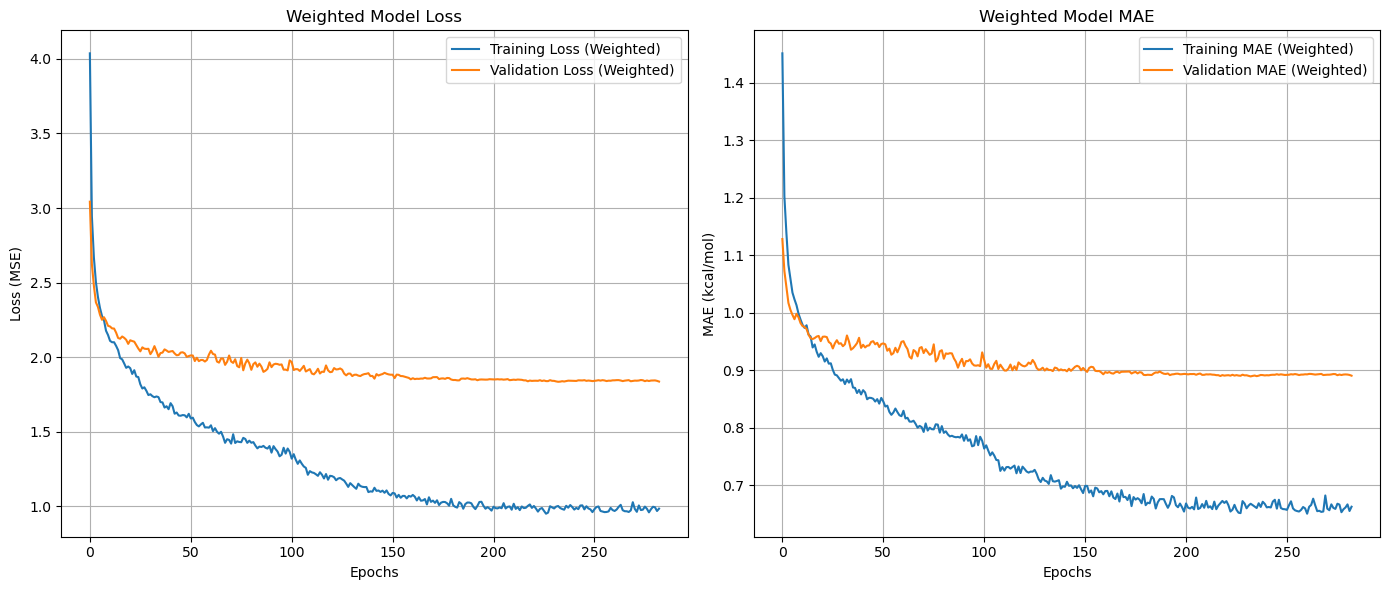

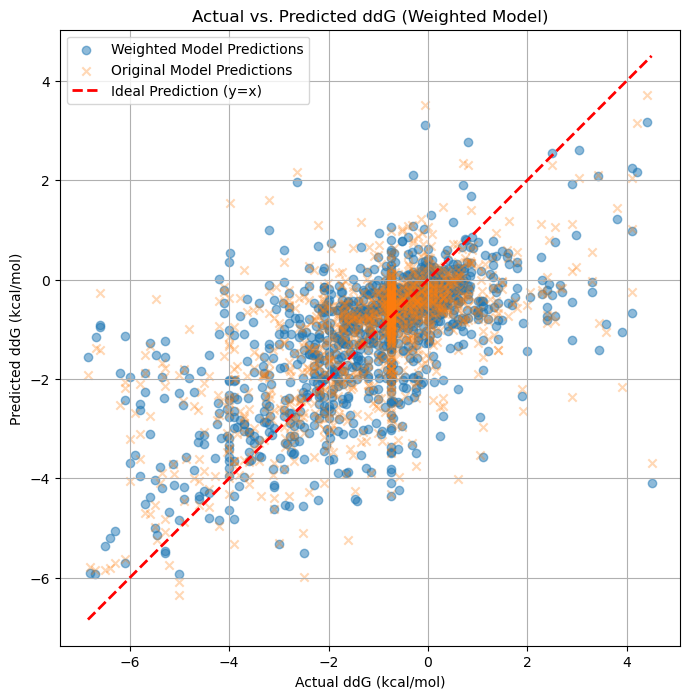

In [137]:
# Plot Training History for Weighted Model
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history_weighted.history['loss'], label='Training Loss (Weighted)')
plt.plot(history_weighted.history['val_loss'], label='Validation Loss (Weighted)')
plt.title('Weighted Model Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss (MSE)'); plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_weighted.history['mae'], label='Training MAE (Weighted)')
plt.plot(history_weighted.history['val_mae'], label='Validation MAE (Weighted)')
plt.title('Weighted Model MAE')
plt.xlabel('Epochs'); plt.ylabel('MAE (kcal/mol)'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

# Plot Actual vs Predicted for Weighted Model
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_w, alpha=0.5, label='Weighted Model Predictions')
plt.scatter(y_test, y_pred, alpha=0.3, label='Original Model Predictions', marker='x') # Optional: overlay original
min_val = min(y_test.min(), y_pred_w.min(), y_pred.min())
max_val = max(y_test.max(), y_pred_w.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal Prediction (y=x)')
plt.xlabel('Actual ddG (kcal/mol)'); plt.ylabel('Predicted ddG (kcal/mol)')
plt.title('Actual vs. Predicted ddG (Weighted Model)')
plt.grid(True); plt.legend(); plt.axis('equal'); plt.show()